# Validate downscaled CRU TS 4.05 data

This notebook is for validating downscaled CRU TS 4.05 data based on previously downscaled CRU TS 4.00 data.

In [1]:
import numpy as np
import rasterio as rio
import xarray as xr
import matplotlib.pyplot as plt
from pathlib import Path

new_pr_dir = Path("/workspace/Shared/Tech_Projects/DeltaDownscaling/project_data/downscaled/ts405/historical/pr/")
old_pr_dir = Path("/workspace/Shared/Tech_Projects/DeltaDownscaling/project_data/downscaled/CRU-TS40/historical/pr/")
new_tas_dir = Path("/workspace/Shared/Tech_Projects/DeltaDownscaling/project_data/downscaled/ts405/historical/tas/")
old_tas_dir = Path("/workspace/Shared/Tech_Projects/DeltaDownscaling/project_data/downscaled/CRU-TS40/historical/tas/")

First, just visually compare some of the same time slices between old (4.00) and new (4.05).

##### January 2000 precipitation

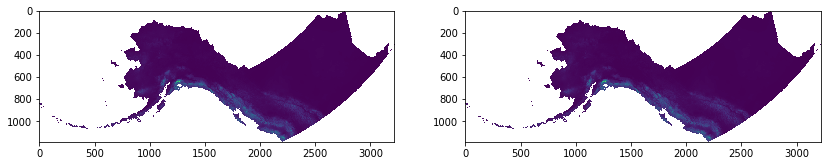

In [142]:
def plot_two_rasters(old_fp, new_fp, sub=False):
    """Plot two rasters side-by-side"""
    fig, axs = plt.subplots(1,2, figsize=(14,7))
    sub_arrs = []
    for fp, i in zip([old_fp, new_fp], [0,1]):
        with rio.open(old_fp) as src:
            arr = src.read(1)
            arr[arr == -9999] = np.nan
            if sub:
                # arbitrary subset of array
                sub_arr = arr[500:700,1100:1300]
            else:
                sub_arr = arr
            sub_arrs.append(sub_arr)
            axs[i].imshow(sub_arr, interpolation="none")

    fig.show()
    
    return sub_arrs

my_str = "01_2000"
new_arr, old_arr = plot_two_rasters(
    list(new_pr_dir.glob(f"*{my_str}*"))[0],
    list(old_pr_dir.glob(f"*{my_str}*"))[0],
)

Check whether the values are equal, and whether metadata are equal:

In [143]:
def equal_rasters(old_fp, new_fp):
    """Check that two rasters are equal"""
    arrs = []
    metas = []
    for fp in [old_fp, new_fp]:
        with rio.open(fp) as src:
            arrs.append(src.read(1))
            metas.append(src.meta)
    
    print("metadata are equal:", metas[0] == metas[1])
    print("values are equal:", np.array_equal(arrs[0], arrs[1]))
    
equal_rasters(
    list(new_pr_dir.glob(f"*{my_str}*"))[0],
    list(old_pr_dir.glob(f"*{my_str}*"))[0],
)

metadata are equal: True
values are equal: False


##### September 1992 temperature

metadata are equal: True
values are equal: False


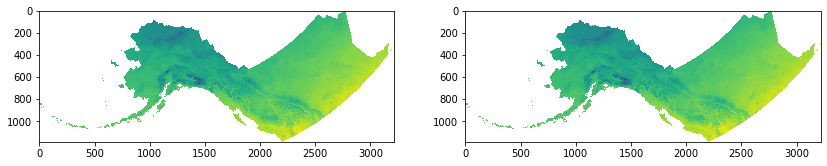

In [144]:
my_str = "09_1992"
plot_two_rasters(
    list(new_tas_dir.glob(f"*{my_str}*"))[0],
    list(old_tas_dir.glob(f"*{my_str}*"))[0],
)

equal_rasters(
    list(new_tas_dir.glob(f"*{my_str}*"))[0],
    list(old_tas_dir.glob(f"*{my_str}*"))[0],
)

Thing look qualitatively similar but not exact matches. Metadata are equal. 

Not sure if we should expect different CRU datasets to be equal where they overlap in time. Compare some time slices from the underlying CRU datasets:

In [145]:
cru_fps = [
    "/Data/Base_Data/Climate/World/CRU_grids/CRU_TS40/cru_ts4.00.1901.2015.pre.dat.nc.gz",
    "/Data/Base_Data/Climate/World/CRU_grids/CRU_TS405/cru_ts4.05.1901.2020.pre.dat.nc",
]

arrs = []
for fp in cru_fps:
    with xr.open_dataset(fp) as ds:
        arrs.append(ds["pre"].sel(time='2000-01-16T00:00:00.000000000').values)
        
print("Underlying CRU datasets match for a single time slice: ", np.array_equal(arrs[0], arrs[1]))

Underlying CRU datasets match for a single time slice:  False


Okay, so the underlying CRU data is not the same between datasets, so we wouldn't expect them to match in the downscaled files. They look qualitatively similar enough to move forward with the validation. Plot a couple of the new files and look at the metadata:

##### May 2018 precipitation

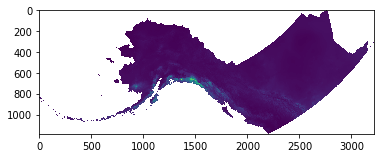

meta: {'driver': 'GTiff', 'dtype': 'float32', 'nodata': -9999.0, 'width': 3218, 'height': 1186, 'count': 1, 'crs': CRS.from_epsg(3338), 'transform': Affine(2000.0, 0.0, -2173223.206087799,
       0.0, -2000.0, 2548412.932644147)}


In [146]:
my_str = "05_2018"
with rio.open(list(new_pr_dir.glob(f"*{my_str}*"))[0]) as src:
    arr = src.read(1)
    meta = src.meta
    
arr[arr == -9999] = np.nan
plt.imshow(arr, interpolation="none")
plt.show()

print("meta:", meta)

##### October 2020 temperature

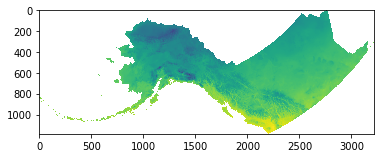

meta: {'driver': 'GTiff', 'dtype': 'float32', 'nodata': -9999.0, 'width': 3218, 'height': 1186, 'count': 1, 'crs': CRS.from_epsg(3338), 'transform': Affine(2000.0, 0.0, -2173223.206087799,
       0.0, -2000.0, 2548412.932644147)}


In [147]:
my_str = "10_2020"
with rio.open(list(new_tas_dir.glob(f"*{my_str}*"))[0]) as src:
    arr = src.read(1)
    meta = src.meta
    
arr[arr == -9999] = np.nan
plt.imshow(arr, interpolation="none")
plt.show()

print("meta:", meta)

Okay, things seem to look okay. Now try iterating through all new files to make sure they open, and verify that all meta data are equal to the metadata from the downscaled CRU TS 4.00:

In [148]:
new_pr_fps = [fp for year in np.arange(2016, 2021) for fp in new_pr_dir.glob(f"*{year}*")]
new_tas_fps = [fp for year in np.arange(2016, 2021) for fp in new_tas_dir.glob(f"*{year}*")]
new_fps = new_pr_fps + new_tas_fps

my_str = "01_1901"
with rio.open(list(old_pr_dir.glob(f"*{my_str}*"))[0]) as src:
    meta = src.meta.copy()

meta_check = []
for fp in new_fps:
    with rio.open(fp) as src:
        meta_check.append(meta == src.meta)
        
print("all files opened and metadata are the same as the downscaled CRU TS 4.00 data: ", np.all(meta_check))

all files opened and metadata are the same as the downscaled CRU TS 4.00 data:  True


Now just open and plot a subset of the new ones, make sure things look OK. I.e., check summaries, 

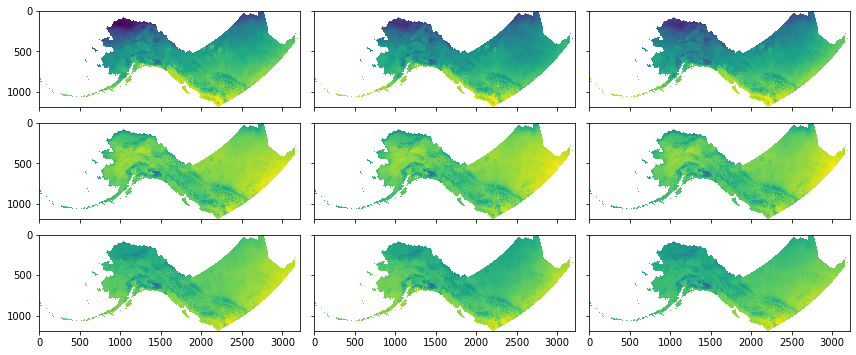

In [14]:
def read_and_plot_values(fp, ax):
    with rio.open(fp) as src:
        arr = src.read(1)
        meta = src.meta

    arr[arr == -9999] = np.nan
    return ax.imshow(arr, interpolation="none")
    
    
fig, ax = plt.subplots(3, 3, figsize=(12, 5), sharex="col", sharey="row")
for i, month in zip(np.arange(3), ["03", "06", "09"]):
    for j, year in zip(np.arange(3), ["2016", "2018", "2020"]):
        my_str = f"{month}_{year}"
        fp = list(new_tas_dir.glob(f"*{my_str}*"))[0]
        ax[i, j] = read_and_plot(fp, ax[i, j])

fig.tight_layout()
plt.show()

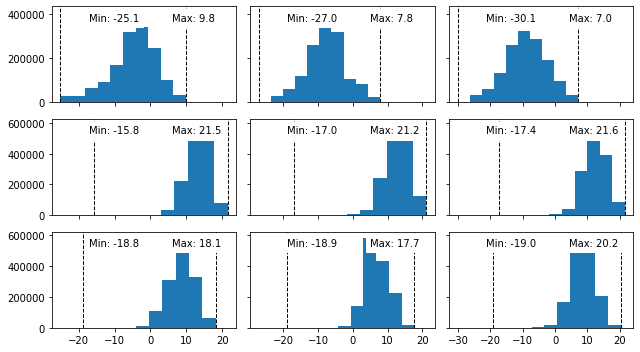

In [19]:
def read_and_plot_histogram(fp, ax):
    with rio.open(fp) as src:
        arr = src.read(1)
        meta = src.meta

    arr[arr == -9999] = np.nan
    ax.hist(arr.flatten())
    # min and max lines
    arr_min = np.nanmin(arr)
    arr_max = np.nanmax(arr)
    ax.axvline(arr_min, color='k', linestyle='dashed', linewidth=1)
    ax.axvline(arr_max, color='k', linestyle='dashed', linewidth=1)
    ax.annotate(
        'Min: {:.1f}'.format(arr_min), 
        xy=(0.2, 0.85), 
        xycoords='axes fraction',
        backgroundcolor="white",
    )
    ax.annotate(
        'Max: {:.1f}'.format(arr_max), 
        xy=(0.65, 0.85), 
        xycoords='axes fraction',
        backgroundcolor="white",
    )
    
    return ax
    
    
fig, ax = plt.subplots(3, 3, figsize=(9, 5), sharex="col", sharey="row")
for i, month in zip(np.arange(3), ["03", "06", "09"]):
    for j, year in zip(np.arange(3), ["2016", "2018", "2020"]):
        my_str = f"{month}_{year}"
        fp = list(new_tas_dir.glob(f"*{my_str}*"))[0]
        ax[i, j] = read_and_plot_histogram(fp, ax[i, j])

fig.tight_layout()
plt.show()

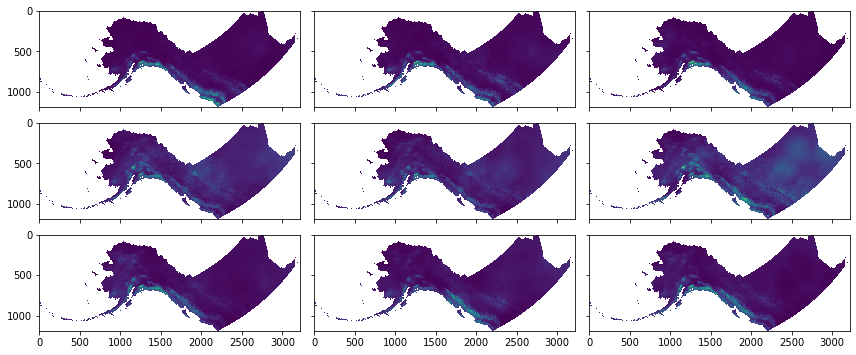

In [20]:
fig, ax = plt.subplots(3, 3, figsize=(12, 5), sharex="col", sharey="row")
for i, month in zip(np.arange(3), ["03", "06", "09"]):
    for j, year in zip(np.arange(3), ["2016", "2018", "2020"]):
        my_str = f"{month}_{year}"
        fp = list(new_pr_dir.glob(f"*{my_str}*"))[0]
        ax[i, j] = read_and_plot(fp, ax[i, j])

fig.tight_layout()
plt.show()

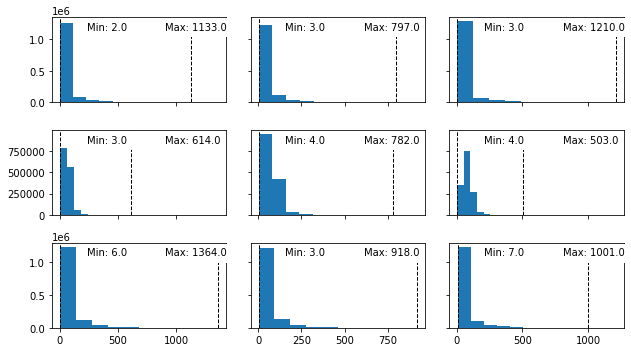

In [21]:
fig, ax = plt.subplots(3, 3, figsize=(9, 5), sharex="col", sharey="row")
for i, month in zip(np.arange(3), ["03", "06", "09"]):
    for j, year in zip(np.arange(3), ["2016", "2018", "2020"]):
        my_str = f"{month}_{year}"
        fp = list(new_pr_dir.glob(f"*{my_str}*"))[0]
        ax[i, j] = read_and_plot_histogram(fp, ax[i, j])

fig.tight_layout()
plt.show()

Finally, ensure all files open and have the same structure.

In [33]:
import time # time this for reference

# test file
with rio.open(list(new_pr_dir.glob(f"*{my_str}*"))[0]) as src:
    test_meta = src.meta
    
# all new files
fps = list(new_pr_dir.glob("*")) + list(new_tas_dir.glob("*"))

tic = time.perf_counter()
results = []
for fp in fps:
    with rio.open(fp) as src:
        results.append(src.meta == test_meta)
        
print("All files open and metadata are consistent:", np.all(results))
print(f"Time: {round(time.perf_counter() - tic, 1)}s")

All files open and metadata are consistent: True
Time: 15.8s
